Using device: cuda
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 249)

Starting training...
Epoc

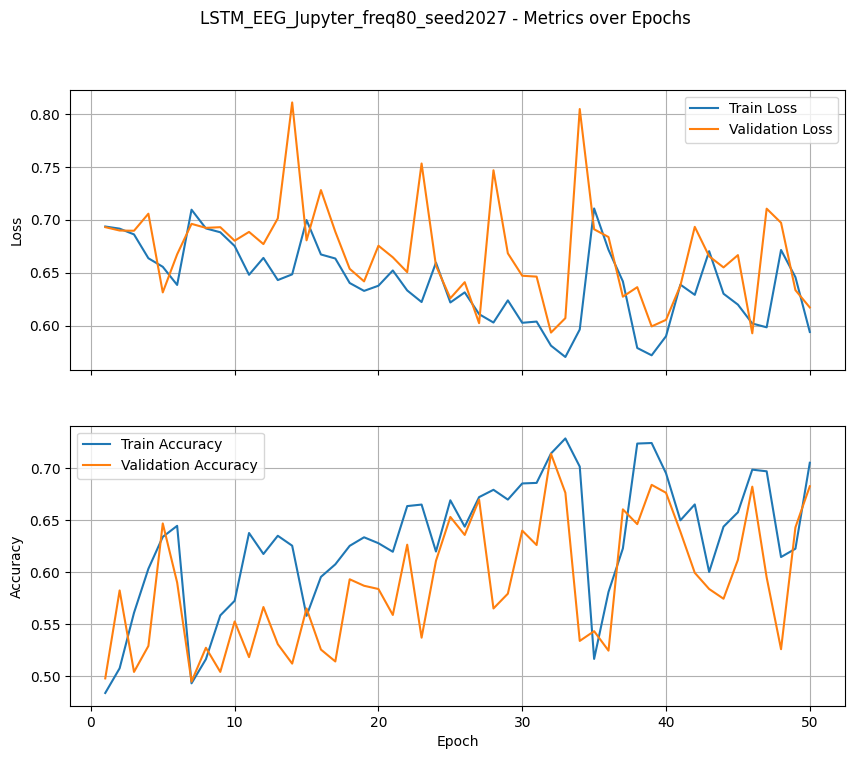

In [3]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace

# Make sure Load_PhysioNet_EEG.py is in the same directory or accessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration
# ===================================================================
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50,  # Number of subjects
    seed=2027     # Random seed
)

# --- Hyperparameters ---
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.001
HIDDEN_SIZE = 64
NUM_LAYERS = 2
exp_name = f"LSTM_EEG_Jupyter_freq{args.freq}_seed{args.seed}"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def calculate_accuracy(y_pred_logit, y_true):
    y_pred_prob = torch.sigmoid(y_pred_logit)
    y_pred_label = (y_pred_prob > 0.5).float()
    correct = (y_pred_label == y_true).sum().item()
    return correct / y_true.size(0)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        acc = calculate_accuracy(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            acc = calculate_accuracy(output, Y_batch)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_acc'], label='Train Accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- Setup ---
torch.manual_seed(args.seed)
np.random.seed(args.seed)
print(f"Using device: {device}")

# --- Data Loading ---
train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
    seed=args.seed, device=device, batch_size=BATCH_SIZE, 
    sampling_freq=args.freq, sample_size=args.n_sample
)

# --- Model Initialization ---
model = LSTMModel(input_size=input_dim[1], hidden_size=HIDDEN_SIZE, output_size=1, num_layers=NUM_LAYERS).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop ---
metrics = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}
print("\nStarting training...")
for epoch in range(EPOCHS):
    start_time = time.time()
    train_loss, train_acc = train_epoch(model, optimizer, train_loader, loss_fn, device)
    val_loss, val_acc = test_epoch(model, val_loader, loss_fn, device)
    test_loss, test_acc = (test_epoch(model, test_loader, loss_fn, device) if epoch == EPOCHS - 1 else (np.nan, np.nan))
    
    metrics['epoch'].append(epoch + 1)
    metrics['train_loss'].append(train_loss); metrics['train_acc'].append(train_acc)
    metrics['val_loss'].append(val_loss); metrics['val_acc'].append(val_acc)
    metrics['test_loss'].append(test_loss); metrics['test_acc'].append(test_acc)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{EPOCHS} [{epoch_time:.2f}s] - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

print("\n--- Training Complete ---")
print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test Acc: {metrics['test_acc'][-1]:.4f}")

save_and_plot_metrics(exp_name, metrics)

### Hyperparameter tuning

STAGE 1: Starting Grid Search using Seed: 2025
Using device: cuda
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set s

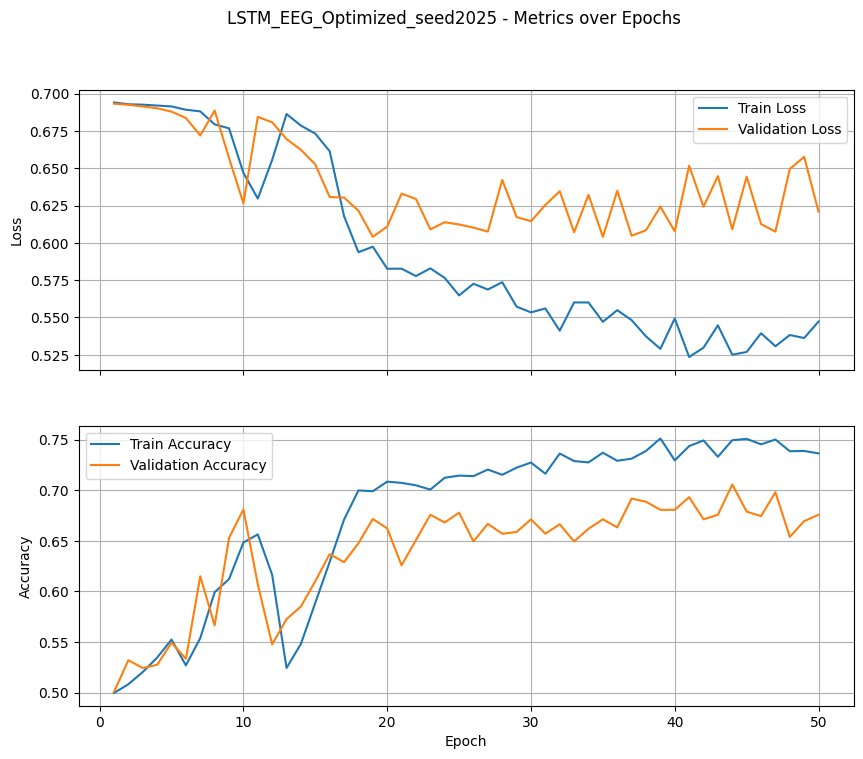


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
77 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
21 bad epochs dropped

Training set shape: (1498, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (339, 64, 2

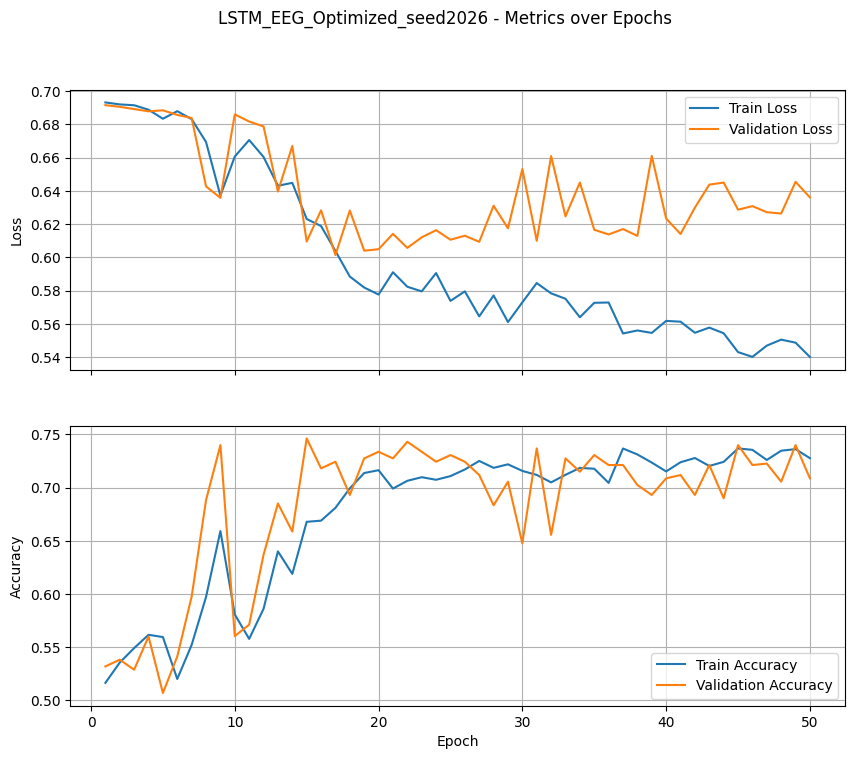


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 2

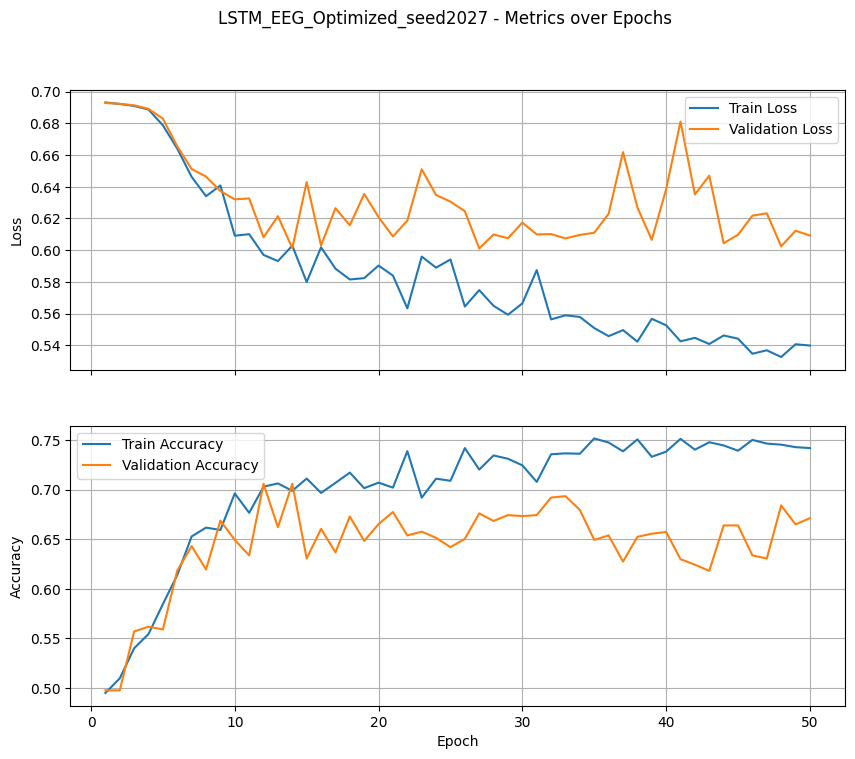


Grid search results saved to LSTM_EEG_Optimized_seed2025/grid_search_results.csv


In [17]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools

# Make sure Load_PhysioNet_EEG.py is in the same directory or accessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50   # Number of subjects
)

# --- Seed Configuration ---
TUNING_SEED = 2025
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
GRID_SEARCH_EPOCHS = 50
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Grid Search Hyperparameters ---
param_grid = {
    'hidden_size': [32, 64],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0005],
    'dropout': [0.2, 0.3]
}

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred_logit, y_true):
    y_pred_prob = torch.sigmoid(y_pred_logit)
    y_pred_label = (y_pred_prob > 0.5).float()
    correct = (y_pred_label == y_true).sum().item()
    return correct / y_true.size(0)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        acc = calculate_accuracy(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            acc = calculate_accuracy(output, Y_batch)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_acc'], label='Train Accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- STAGE 1: HYPERPARAMETER TUNING ON A SINGLE SEED ---
print("="*50)
print(f"STAGE 1: Starting Grid Search using Seed: {TUNING_SEED}")
print("="*50)

# --- Setup and Data Loading for Tuning ---
torch.manual_seed(TUNING_SEED)
np.random.seed(TUNING_SEED)
print(f"Using device: {device}")
train_loader, val_loader, _, input_dim = load_eeg_ts_revised(
    seed=TUNING_SEED, device=device, batch_size=BATCH_SIZE, 
    sampling_freq=args.freq, sample_size=args.n_sample
)

# --- Grid Search ---
best_val_acc = 0.0
best_params = {}
grid_search_results = []

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

for i, params in enumerate(param_combinations):
    print(f"\n[{i+1}/{len(param_combinations)}] Testing params: {params}")
    
    model = LSTMModel(
        input_size=input_dim[1], hidden_size=params['hidden_size'], 
        output_size=1, num_layers=params['num_layers'], dropout=params['dropout']
    ).to(device)
    
    print(f"Number of trainable parameters: {count_parameters(model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])

    for epoch in range(GRID_SEARCH_EPOCHS):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader, loss_fn, device)
    
    val_loss, val_acc = test_epoch(model, val_loader, loss_fn, device)
    print(f"Validation Accuracy for params {params}: {val_acc:.4f}")
    grid_search_results.append({'params': str(params), 'val_acc': val_acc})

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = params

print(f"\n--- Grid Search Complete ---")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Hyperparameters Found: {best_params}")

# --- STAGE 2: FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_Optimized_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=best_params['hidden_size'], 
        output_size=1, num_layers=best_params['num_layers'], dropout=best_params['dropout']
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

    metrics = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_acc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_acc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss); metrics['val_acc'].append(val_acc)
        metrics['test_loss'].append(test_loss); metrics['test_acc'].append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test Acc: {metrics['test_acc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_Optimized_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")


### Parameter-constrained setting


STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 249)
Final model parameters for seed 2025: 5,265
Epoch 10/50 - Train Acc: 0.5173, Val Acc: 0.5649
Epoch 20/50 - Train Acc: 0.6594, Va

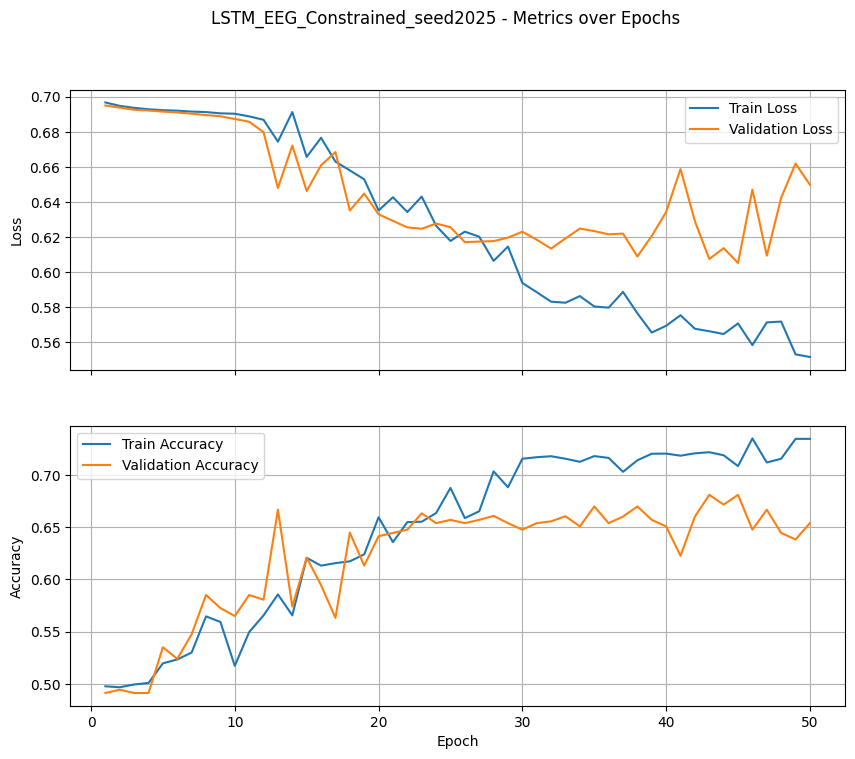


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
77 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
21 bad epochs dropped

Training set shape: (1498, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (339, 64, 2

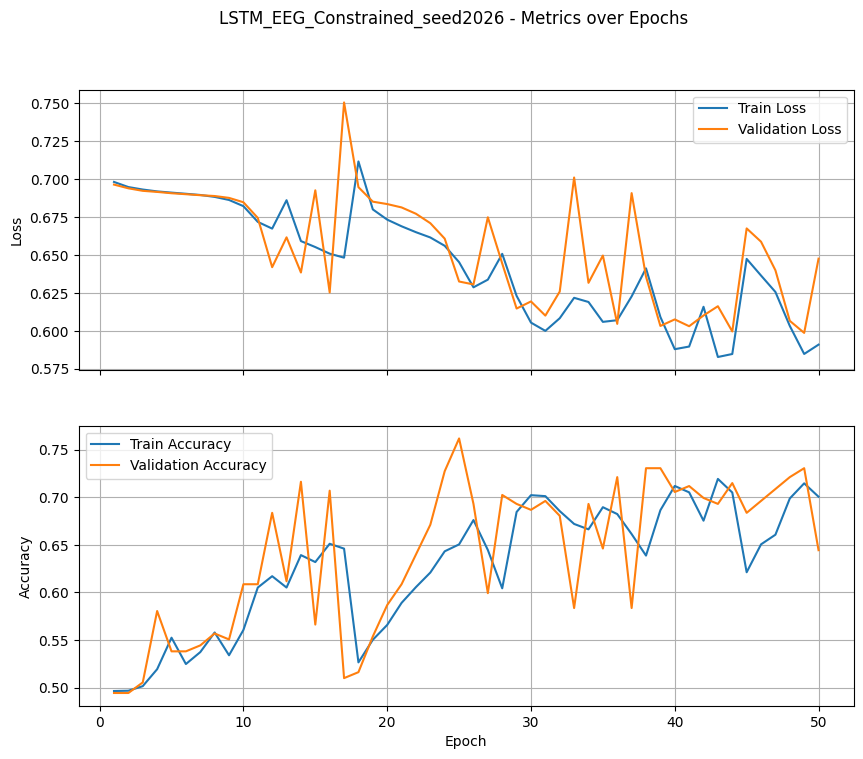


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 35
Subjects in Validation Set: 7
Subjects in Test Set: 8
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
1575 matching events found
No baseline correction applied
Using data from preloaded Raw for 1575 events and 249 original time points ...
83 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
315 matching events found
No baseline correction applied
Using data from preloaded Raw for 315 events and 249 original time points ...
18 bad epochs dropped
Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
360 matching events found
No baseline correction applied
Using data from preloaded Raw for 360 events and 249 original time points ...
15 bad epochs dropped

Training set shape: (1492, 64, 249)
Validation set shape: (297, 64, 249)
Test set shape: (345, 64, 2

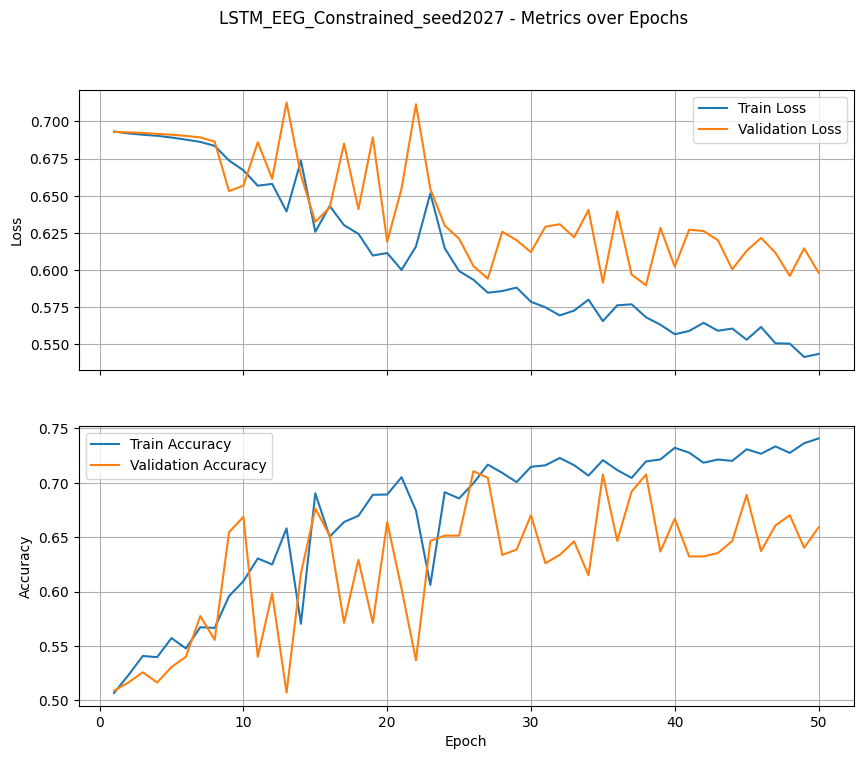


Grid search results saved to LSTM_EEG_Constrained_seed2025/grid_search_results.csv


In [18]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools

# Make sure Load_PhysioNet_EEG.py is in the same directory or accessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=50   # Number of subjects
)

# --- Seed Configuration ---
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---q
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred_logit, y_true):
    y_pred_prob = torch.sigmoid(y_pred_logit)
    y_pred_label = (y_pred_prob > 0.5).float()
    correct = (y_pred_label == y_true).sum().item()
    return correct / y_true.size(0)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = loss_fn(output, Y_batch)
        acc = calculate_accuracy(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze()
            loss = loss_fn(output, Y_batch)
            acc = calculate_accuracy(output, Y_batch)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_acc'], label='Train Accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_Constrained_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=16, 
        output_size=1, num_layers=1, dropout=0.3
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)

    metrics = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_acc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_acc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss); metrics['val_acc'].append(val_acc)
        metrics['test_loss'].append(test_loss); metrics['test_acc'].append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test Acc: {metrics['test_acc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_Constrained_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")


### Different sample sizes


STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (300, 64, 249)
Validation set shape: (42, 64, 249)
Test set shape: (87, 64, 249)
Final model parameters for seed 2025: 33,345
Epoch 10/50 - Train Acc: 0.5771, Val Acc: 0.5000
Epoch 20/50 - Train Acc: 0.7042, Val Acc: 0.5000
Epoch 30/50 - Train Acc: 0.7260, Val Acc: 0.5469
Epoch 40/50 - Train Acc: 0.7896, Val Acc: 0.5781
Epoch 50/50 - Train Acc: 0.7927, Val Acc: 0.5469

--- Final Training Complete for Seed 2025 ---
Final Test Loss: 0.7180, Final Test Acc: 0.6173
Metrics saved to LSTM_EEG_N_10_seed2025/final_training_metrics.csv
Plot saved to LSTM_EEG_N_10_seed2025/metrics_plot.png


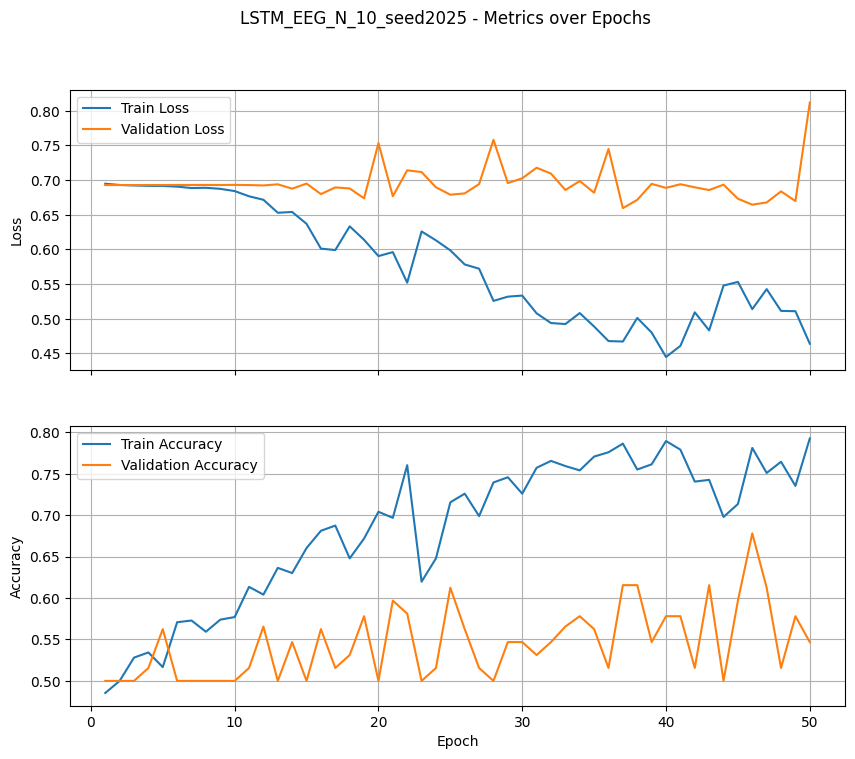


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (303, 64, 249)
Validation set shape: (42, 64, 249)
Test set shape: (84, 64, 249)
Final model parameters for seed 2026: 33,345
Epoch 10/50 - Train Acc: 0.6006, Val Acc: 0.6656
Epoch 20/50 - Train Acc: 0.6175, Val Acc: 0.7156
Epoch 30/50 - Train Acc: 0.6671, Val Acc: 0.7125
Epoch 40/50 - Train Acc: 0.7206, Val Acc: 0.7469
Epoch 50/50 - Train Acc: 0.7100, Val Acc: 0.6969

--- Final Training Complete for Seed 2026 ---
Final Test Loss: 0.7773, Final Test Acc: 0.6458
Metrics saved to LSTM_EEG_N_10_seed2026/final_training_metrics.csv
Plot saved to LSTM_EEG_N_10_seed2026/metrics_plot.png


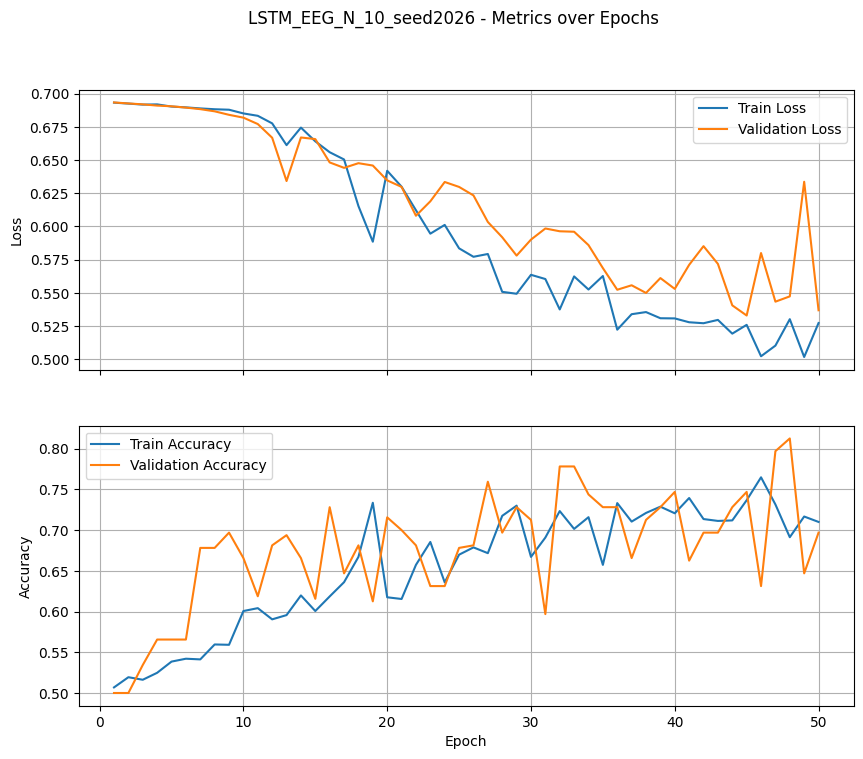


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (300, 64, 249)
Validation set shape: (45, 64, 249)
Test set shape: (84, 64, 249)
Final model parameters for seed 2027: 33,345
Epoch 10/50 - Train Acc: 0.5490, Val Acc: 0.4495
Epoch 20/50 - Train Acc: 0.6521, Val Acc: 0.6815
Epoch 30/50 - Train Acc: 0.6635, Val Acc: 0.7680
Epoch 40/50 - Train Acc: 0.7438, Val Acc: 0.7752
Epoch 50/50 - Train Acc: 0.7917, Val Acc: 0.7524

--- Final Training Complete for Seed 2027 ---
Final Test Loss: 0.6860, Final Test Acc: 0.5771
Metrics saved to LSTM_EEG_N_10_seed2027/final_training_metrics.csv
Plot saved to LSTM_EEG_N_10_seed2027/metrics_plot.png


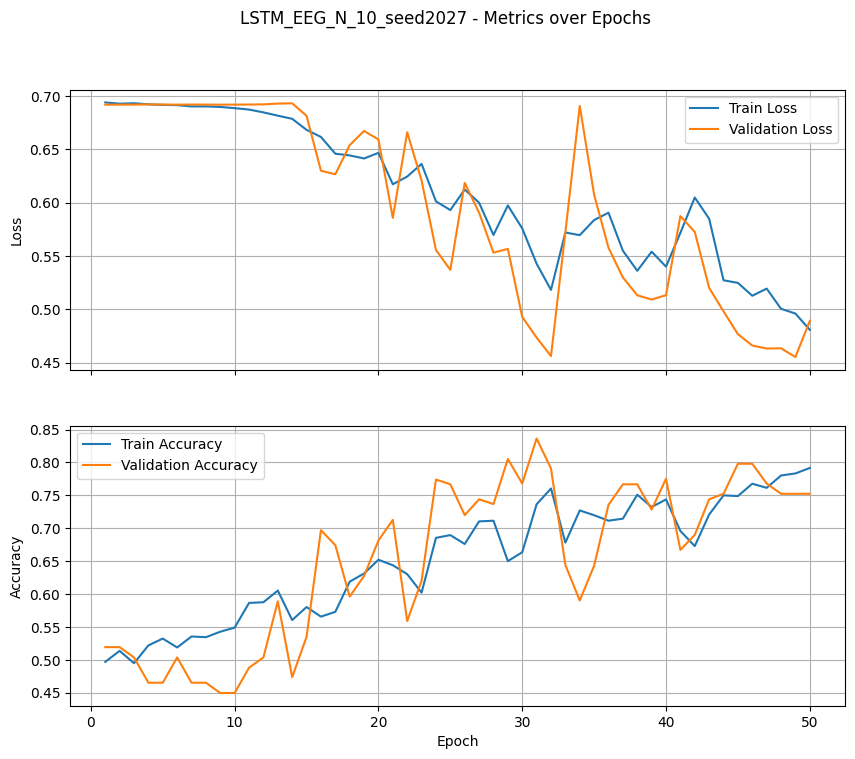


Grid search results saved to LSTM_EEG_N_10_seed2025/grid_search_results.csv


In [22]:
import torch
import torch.nn as nn
import numpy as np
import os
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools

# Make sure Load_PhysioNet_EEG.py is in the same directory or accessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=10   # Number of subjects
)

# --- Seed Configuration ---
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---q
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1) # (batch, channels, seq_len) -> (batch, seq_len, channels)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred_logit, y_true):
    y_pred_prob = torch.sigmoid(y_pred_logit)
    y_pred_label = (y_pred_prob > 0.5).float()
    correct = (y_pred_label == y_true).sum().item()
    return correct / y_true.size(0)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train()
    total_loss, total_acc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze(-1)
        loss = loss_fn(output, Y_batch)
        acc = calculate_accuracy(output, Y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze(-1)
            loss = loss_fn(output, Y_batch)
            acc = calculate_accuracy(output, Y_batch)
            total_loss += loss.item()
            total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name):
        os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_acc'], label='Train Accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"LSTM_EEG_N_10_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = LSTMModel(
        input_size=input_dim[1], hidden_size=64, 
        output_size=1, num_layers=1, dropout=0.3
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0005)

    metrics = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_acc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_acc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss); metrics['val_acc'].append(val_acc)
        metrics['test_loss'].append(test_loss); metrics['test_acc'].append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test Acc: {metrics['test_acc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"LSTM_EEG_N_10_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")



STAGE 2: Starting Final Evaluation for Seeds: [2025, 2026, 2027]

--- Running Final Experiment for Seed: 2025 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (300, 64, 249)
Validation set shape: (42, 64, 249)
Test set shape: (87, 64, 249)
Final model parameters for seed 2025: 104,641
Epoch 10/50 - Train Acc: 0.6052, Val Acc: 0.5000
Epoch 20/50 - Train Acc: 0.7823, Val Acc: 0.7781
Epoch 30/50 - Train Acc: 0.8562, Val Acc: 0.5312
Epoch 40/50 - Train Acc: 0.8615, Val Acc: 0.5469
Epoch 50/50 - Train Acc: 0.8792, Val Acc: 0.6625

--- Final Training Complete for Seed 2025 ---
Final Test Loss: 0.8103, Final Test Acc: 0.5177
Metrics saved to Transformer_EEG_N_10_seed2025/final_training_metrics.csv
Plot saved to Transformer_EEG_N_10_seed2025/metrics_plot.png


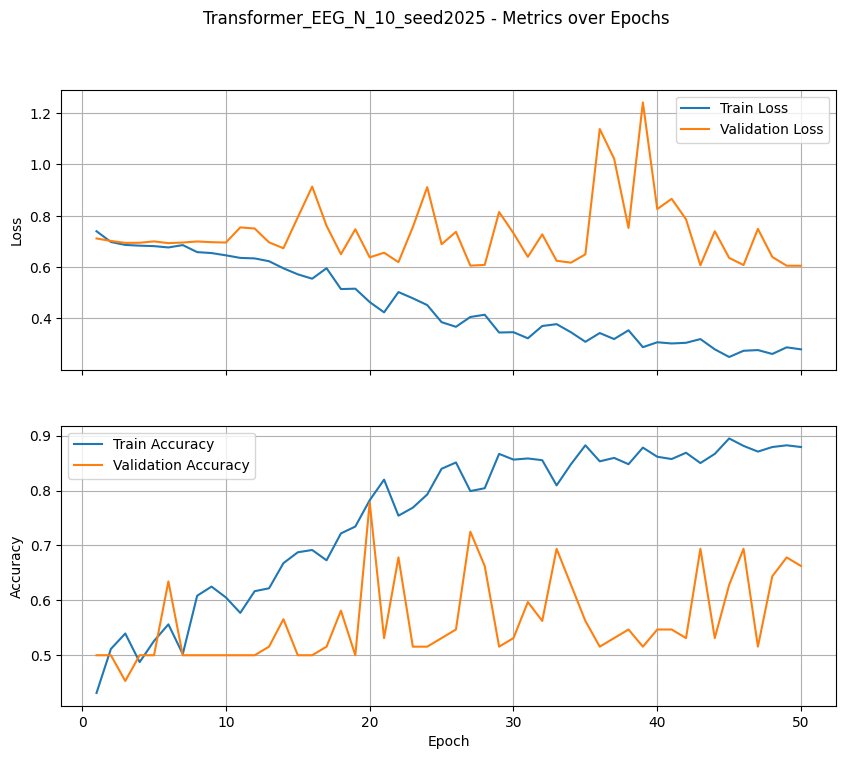


--- Running Final Experiment for Seed: 2026 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (303, 64, 249)
Validation set shape: (42, 64, 249)
Test set shape: (84, 64, 249)
Final model parameters for seed 2026: 104,641
Epoch 10/50 - Train Acc: 0.5940, Val Acc: 0.5000
Epoch 20/50 - Train Acc: 0.7194, Val Acc: 0.7125
Epoch 30/50 - Train Acc: 0.7483, Val Acc: 0.7125
Epoch 40/50 - Train Acc: 0.7452, Val Acc: 0.7125
Epoch 50/50 - Train Acc: 0.7706, Val Acc: 0.7125

--- Final Training Complete for Seed 2026 ---
Final Test Loss: 0.8411, Final Test Acc: 0.7125
Metrics saved to Transformer_EEG_N_10_seed2026/final_training_metrics.csv
Plot saved to Transformer_EEG_N_10_seed2026/metrics_plot.png


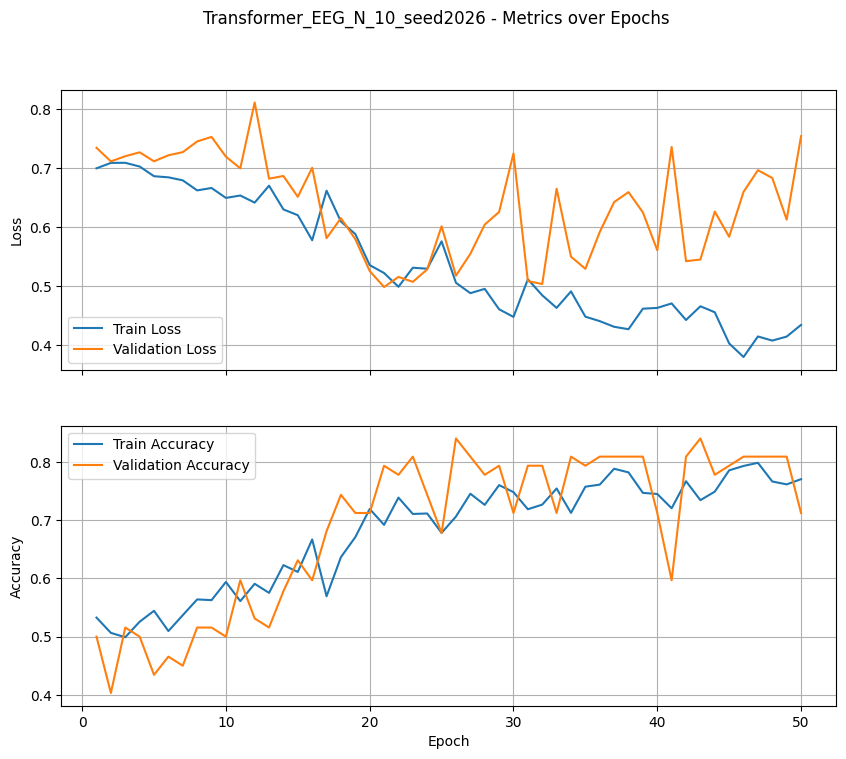


--- Running Final Experiment for Seed: 2027 ---
Subjects in Training Set: 7
Subjects in Validation Set: 1
Subjects in Test Set: 2

Training set shape: (300, 64, 249)
Validation set shape: (45, 64, 249)
Test set shape: (84, 64, 249)
Final model parameters for seed 2027: 104,641
Epoch 10/50 - Train Acc: 0.5792, Val Acc: 0.7740
Epoch 20/50 - Train Acc: 0.7292, Val Acc: 0.7752
Epoch 30/50 - Train Acc: 0.7292, Val Acc: 0.6599
Epoch 40/50 - Train Acc: 0.8135, Val Acc: 0.5120
Epoch 50/50 - Train Acc: 0.8510, Val Acc: 0.7825

--- Final Training Complete for Seed 2027 ---
Final Test Loss: 0.7555, Final Test Acc: 0.5625
Metrics saved to Transformer_EEG_N_10_seed2027/final_training_metrics.csv
Plot saved to Transformer_EEG_N_10_seed2027/metrics_plot.png


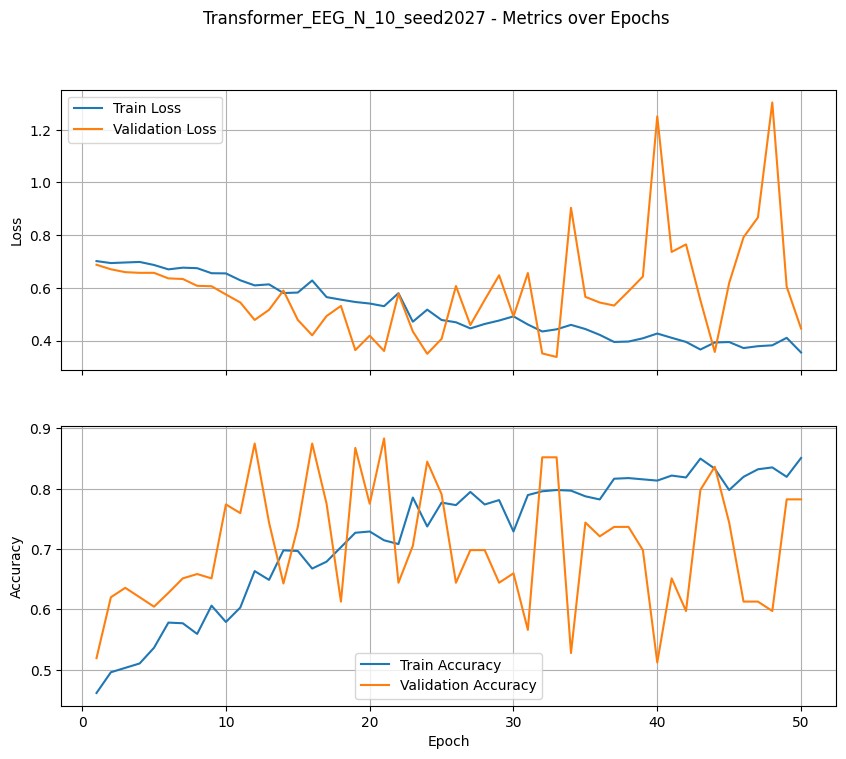


Grid search results saved to Transformer_EEG_N_10_seed2025/grid_search_results.csv


In [26]:
import torch
import torch.nn as nn
import numpy as np
import os
import math
import time
from datetime import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
from types import SimpleNamespace
import itertools

# Make sure Load_PhysioNet_EEG.py is in the same directory or accessible
from Load_PhysioNet_EEG import load_eeg_ts_revised

# ===================================================================
# 1. Configuration and Hyperparameter Grid
# ===================================================================
# --- Data Configuration ---
args = SimpleNamespace(
    freq=80,      # Sampling frequency
    n_sample=10   # Number of subjects
)

# --- Seed Configuration ---
EVALUATION_SEEDS = [2025, 2026, 2027]

# --- Training Configuration ---
FINAL_EPOCHS = 50
BATCH_SIZE = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===================================================================
# 2. Model Definition
# ===================================================================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_size, d_model, nhead, d_hid, nlayers, output_size, dropout=0.3):
        super(TransformerModel, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, d_hid, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, output_size)

    def forward(self, src):
        src = src.permute(0, 2, 1) # -> (batch, seq_len, channels)
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = output.mean(dim=1) # Mean pooling
        output = self.decoder(output)
        return output

# ===================================================================
# 3. Helper Functions
# ===================================================================
def count_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_accuracy(y_pred_logit, y_true):
    y_pred_prob = torch.sigmoid(y_pred_logit)
    y_pred_label = (y_pred_prob > 0.5).float()
    correct = (y_pred_label == y_true).sum().item()
    return correct / y_true.size(0)

def train_epoch(model, optimizer, loader, loss_fn, device):
    model.train(); total_loss, total_acc = 0, 0
    for X_batch, Y_batch in loader:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze(-1)
        loss = loss_fn(output, Y_batch)
        acc = calculate_accuracy(output, Y_batch)
        loss.backward(); optimizer.step()
        total_loss += loss.item(); total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def test_epoch(model, loader, loss_fn, device):
    model.eval(); total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            output = model(X_batch).squeeze(-1)
            loss = loss_fn(output, Y_batch)
            acc = calculate_accuracy(output, Y_batch)
            total_loss += loss.item(); total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

def save_and_plot_metrics(exp_name, metrics_data):
    if not os.path.exists(exp_name): os.makedirs(exp_name)
    df_metrics = DataFrame(metrics_data)
    csv_path = os.path.join(exp_name, "final_training_metrics.csv")
    df_metrics.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax1.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
    ax1.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
    ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
    ax2.plot(df_metrics['epoch'], df_metrics['train_acc'], label='Train Accuracy')
    ax2.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
    ax2.set_ylabel('Accuracy'); ax2.set_xlabel('Epoch'); ax2.legend(); ax2.grid(True)
    fig.suptitle(f'{exp_name} - Metrics over Epochs')
    plot_path = os.path.join(exp_name, "metrics_plot.png")
    plt.savefig(plot_path)
    print(f"Plot saved to {plot_path}")
    plt.show()

# ===================================================================
# 4. Main Execution Block
# ===================================================================
# --- FINAL EVALUATION ON MULTIPLE SEEDS ---
print("\n" + "="*50)
print(f"STAGE 2: Starting Final Evaluation for Seeds: {EVALUATION_SEEDS}")
print("="*50)

for seed in EVALUATION_SEEDS:
    print(f"\n--- Running Final Experiment for Seed: {seed} ---")
    exp_name = f"Transformer_EEG_N_10_seed{seed}"
    
    torch.manual_seed(seed)
    np.random.seed(seed)

    train_loader, val_loader, test_loader, input_dim = load_eeg_ts_revised(
        seed=seed, device=device, batch_size=BATCH_SIZE, 
        sampling_freq=args.freq, sample_size=args.n_sample
    )
    
    final_model = TransformerModel(
        input_size=input_dim[1], d_model=64, nhead=4,
        d_hid=64 * 2, nlayers=3, output_size=1, dropout=0.4
    ).to(device)
    
    print(f"Final model parameters for seed {seed}: {count_parameters(final_model):,}")
    
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.0005)

    metrics = {'epoch': [], 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'test_loss': [], 'test_acc': []}
    for epoch in range(FINAL_EPOCHS):
        start_time = time.time()
        train_loss, train_acc = train_epoch(final_model, optimizer, train_loader, loss_fn, device)
        val_loss, val_acc = test_epoch(final_model, val_loader, loss_fn, device)
        test_loss, test_acc = (test_epoch(final_model, test_loader, loss_fn, device) if epoch == FINAL_EPOCHS - 1 else (np.nan, np.nan))
        
        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss); metrics['train_acc'].append(train_acc)
        metrics['val_loss'].append(val_loss); metrics['val_acc'].append(val_acc)
        metrics['test_loss'].append(test_loss); metrics['test_acc'].append(test_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{FINAL_EPOCHS} - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    print(f"\n--- Final Training Complete for Seed {seed} ---")
    print(f"Final Test Loss: {metrics['test_loss'][-1]:.4f}, Final Test Acc: {metrics['test_acc'][-1]:.4f}")

    save_and_plot_metrics(exp_name, metrics)

first_eval_folder = f"Transformer_EEG_N_10_seed{EVALUATION_SEEDS[0]}"
df_grid = DataFrame(grid_search_results)
grid_csv_path = os.path.join(first_eval_folder, "grid_search_results.csv")
df_grid.to_csv(grid_csv_path, index=False)
print(f"\nGrid search results saved to {grid_csv_path}")
